Starting Portfolio Value: 100.00
2019-01-03, Close, 1.1370
2019-01-03, Open: 1.14, High: 1.14, Low: 1.14, Close: 1.14, u: 1.13821, b: 1.13536, l: 1.13251
2019-01-03, Open: 1.14, High: 1.14, Low: 1.14, Close: 1.14, bbu: 1.13924, bbb: 1.13536, bbl: 1.13147
Squeeze
sqzOff
2019-01-03, Close, 1.1380
2019-01-03, Open: 1.14, High: 1.14, Low: 1.14, Close: 1.14, u: 1.13824, b: 1.13523, l: 1.13222
2019-01-03, Open: 1.14, High: 1.14, Low: 1.14, Close: 1.14, bbu: 1.13857, bbb: 1.13523, bbl: 1.13189
Squeeze
sqzOn
2019-01-03, Close, 1.1376
2019-01-03, Open: 1.14, High: 1.14, Low: 1.14, Close: 1.14, u: 1.13813, b: 1.13525, l: 1.13237
2019-01-03, Open: 1.14, High: 1.14, Low: 1.14, Close: 1.14, bbu: 1.13864, bbb: 1.13525, bbl: 1.13186
Squeeze
sqzOn
2019-01-03, Close, 1.1368
2019-01-03, Open: 1.14, High: 1.14, Low: 1.14, Close: 1.14, u: 1.13812, b: 1.13529, l: 1.13246
2019-01-03, Open: 1.14, High: 1.14, Low: 1.14, Close: 1.14, bbu: 1.13873, bbb: 1.13529, bbl: 1.13185
Squeeze
sqzOff
2019-01-03, SELL CREA

<IPython.core.display.Javascript object>


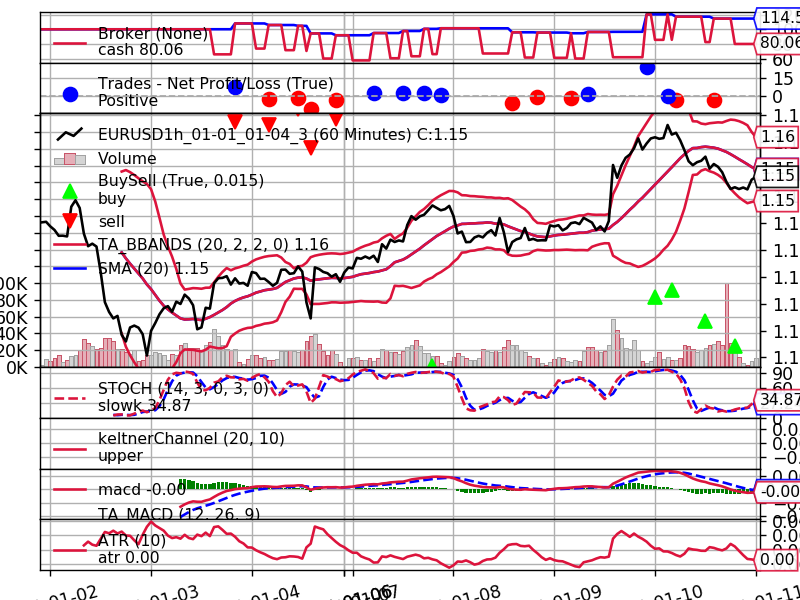

Final Portfolio Value: 114.59
Final Portfolio Value: $114.59050000000208
P/L: $14.59050000000208


In [1]:

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import backtrader.feeds as btfeed


   
class keltnerChannel(bt.Indicator):
    lines = ('upper', 'basis', 'lower',)
    params = (('ema', 20), ('period', 10),)
    
    def __init__(self):
#        self.addminperiod(self.p.period)
        self.basis = bt.indicators.EMA(self.data, period=self.p.ema)
        atr = bt.indicators.ATR(self.data, period=self.p.period)
        self.upper = self.basis.lines.ema + 1 * atr.lines.atr
        self.lower = self.basis.lines.ema - 1 * atr.lines.atr
        

class setUpTrigger():
    
    def __init__(self, stoch, keltnerChannel, bbands, basis_sma, atr):
        self.stoch = stoch
        self.stochk = stoch.slowk[0]
        self.stochd = stoch.slowd[0]
            
        self.keltnerChannel_upper = basis_sma.lines.sma[0] + (1.8 * atr.lines.atr[0])
        self.keltnerChannel_lower = basis_sma.lines.sma[0] - (1.8 * atr.lines.atr[0])
        self.keltnerChannel_basis = basis_sma.lines.sma[0]
        
        self.bband_upper = bbands.upperband[0]
        self.bband_lower = bbands.lowerband[0]
        self.bband_basis = bbands.middleband[0]
        
        self.status = self.stochastic_logic()
        self.squeeze = self.TTM_squeeze_clone()
        
        self.msg = "Message goes here"
        
    def stochastic_logic(self):
        # BUY and SELL Stochastic Logic
        if self.stoch.slowk[-1] < self.stoch.slowd[-1] and self.stoch.slowk[0] > self.stoch.slowd[0]:
            return "buy"

        elif self.stoch.slowk[-1] > self.stoch.slowd[-1] and self.stoch.slowk[0] < self.stoch.slowd[0]:
            return "sell"
        
    def TTM_squeeze_clone (self):
        # TTM Squeeze CLone        
        if self.bband_lower > self.keltnerChannel_lower and self.bband_upper < self.keltnerChannel_upper:
            return "sqzOn"

        elif self.bband_lower < self.keltnerChannel_lower and self.bband_upper > self.keltnerChannel_upper:
            return "sqzOff"
        
        else:
            return "noSqz"
        
    
    def TTM_squeeze_clone_hist (self):
        # TTM Squeeze CLone Histogram
        

        
        
        
        
        
        
class moneyManagement():
    
    def __init__(self, position , data):
        self.position = position
        self.dataclose = data.close
        self.datahigh = data.high
        self.datalow = data.low
        
    def exitcommand(self):
        
        # Exit command
        if self.position == "buy" and self.datalow[0] > self.dataclose[0]:
            print("Custom Close called")
            return True
        elif self.position == "sell"  and self.datahigh[0] < self.dataclose[0]:
            print("Custom Close called")
            return True
        else:
            return False
        
    def size_position(self, price, stop, risk, acc_value, method=0, exchange_rate=None, JPY_pair=False):

        if JPY_pair == True: #check if a YEN cross and change the multiplier
            multiplier = 0.01
        else:
            multiplier = 0.0001

        #Calc how much to risk
        acc_value = acc_value    
        cash_risk = acc_value * risk
        stop_pips_int = abs((price - stop) / multiplier)
        pip_value = cash_risk / stop_pips_int

        if method == 1:
            #pip_value = pip_value * price
            units = pip_value / multiplier
            return units

        elif method == 2:
            pip_value = pip_value * exchange_rate
            units = pip_value / multiplier
            return units

        else: # is method 0
            units = pip_value / multiplier
            return units
        
    
    



class forexSpreadCommisionScheme(bt.CommInfoBase):
    '''
    This commission scheme attempts to calcuate the commission hidden in the
    spread by most forex brokers. It assumes a mid point data is being used.

    *New Params*
    spread: Float, the spread in pips of the instrument
    JPY_pair: Bool, states whether the pair being traded is a JPY pair
    acc_counter_currency: Bool, states whether the account currency is the same
    as the counter currency. If false, it is assumed to be the base currency
    '''
    params = (
        ('spread', 2),
        ('stocklike', False),
        ('JPY_pair', False),
        ('acc_counter_currency', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED),
        )

    
    def _getcommission(self, size, price, pseudoexec):
        '''
        This scheme will apply half the commission when buying and half when selling.
        If JPY pair change the multiplier accordingly.
        If account currency is same as the base currency, change pip value calc.
        '''
        if self.p.JPY_pair == True:
            multiplier = 0.01
        else:
            multiplier = 0.0001

        if self.p.acc_counter_currency == True:
            comm = abs((self.p.spread * (size * multiplier)/2))

        else:
            comm =  abs((self.p.spread * ((size / price) * multiplier)/2))

        return comm
    
    
    
    
    
    
    
    
    
    
    
    
    
    
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = dict(
        stop_loss=0.02,  # price is 2% less than the entry point
        trail=False,
    )
    
    
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

        
        
        
        
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low
        
         # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.setclose = None
        self.setposition = None
        
        
        # Add Stochastic indicator        
        self.stoch  = bt.talib.STOCH(self.data.high, self.data.low, self.data.close,
                                   fastk_period=14, slowk_period=3, slowd_period=3)
        
        # Add Bollinger Band indicator       
        self.bbands  = bt.talib.BBANDS(self.data, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0, plotname='TA_BBANDS')
        
        # Initialise Keltner Channel
        self.keltnerChannel = keltnerChannel(self.data)
        
        # MACD
        self.macd = bt.talib.MACD(self.data, plotname='TA_MACD')
        
        # EMA
        self.basis = bt.indicators.SMA(self.data, period=20)
        
        # Average True Range
        self.atr = bt.indicators.ATR(self.data, period=10)
        
        
        # True Range MA
#         self.rangema = bt.indicators.ATR(self.atr.lines.atr, period=10)
        
        
        
        
        

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                        (order.executed.price,
                         order.executed.value,
                         order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                        (order.executed.price,
                         order.executed.value,
                         order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

        
        
        
        
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
        # Print out the final result
        print('Current Portfolio Value: %.2f' % cerebro.broker.getvalue())

        
        
        
        
        
    
    
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.4f' % self.dataclose[0])
        
        
#         print(self.basis.lines.ema[0])
#         print(self.atr.lines.atr[0])

# ma = sma(source, lengthKC)
# range = useTrueRange ? tr : (high - low)
# rangema = sma(range, lengthKC)
# upperKC = ma + rangema * multKC
# lowerKC = ma - rangema * multKC
        
        self.keltnerChannel_upper = self.basis.lines.sma[0] + (1.5 * self.atr.lines.atr[0])
        self.keltnerChannel_lower = self.basis.lines.sma[0] - (1.5 * self.atr.lines.atr[0])
        self.keltnerChannel_basis = self.basis.lines.sma[0]
        
        
        self.log('Open: %.2f, High: %.2f, Low: %.2f, Close: %.2f, u: %.5f, b: %.5f, l: %.5f'
                 %(self.data.open[0], self.data.high[0], 
                   self.data.low[0], self.data.close[0],
                   self.keltnerChannel_upper, self.keltnerChannel_basis,
                   self.keltnerChannel_lower
                  ))

        self.log('Open: %.2f, High: %.2f, Low: %.2f, Close: %.2f, bbu: %.5f, bbb: %.5f, bbl: %.5f'
                 %(self.data.open[0], self.data.high[0], 
                   self.data.low[0], self.data.close[0],
                   self.bbands.upperband[0], self.bbands.middleband[0],
                   self.bbands.lowerband[0]
                  ))

     
        
        
        
        # Initialise SetupClass
        setup = setUpTrigger(self.stoch, self.keltnerChannel, self.bbands, self.basis, self.atr)        
        trigger = setup.status
        
        print('Squeeze')
        print(setup.squeeze)
        
        # Money Management Class
        risk = moneyManagement(self.setposition, self.datas[0])

        
        # Exit command
        if risk.exitcommand():
            print("Custom Close called")
            self.close()
        
            
            
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        
        
        # BUY and SELL Logic
        if trigger == "buy":
            self.setposition = "buy"
            
            # BUY, BUY, BUY!!! (with all possible default parameters)
            self.log('BUY CREATE, %.2f' % self.dataclose[0])
            self.close()
            
            # Keep track of the created order to avoid a 2nd order
            #self.order = self.buy()
            
            if not self.p.trail:
                stop_price = self.data.close[0] * (1.0 - self.p.stop_loss)
                self.buy(exectype=bt.Order.Stop, price=stop_price)
            else:
                self.buy(exectype=bt.Order.StopTrail,
                          trailamount=self.p.trail)

        elif trigger == "sell":
            self.setposition = "sell"
            
            # SELL, SELL, SELL!!! (with all possible default parameters)
            self.log('SELL CREATE, %.2f' % self.dataclose[0])
            self.close()
            
            # Keep track of the created order to avoid a 2nd order
            #self.order = self.sell()
            
            if not self.p.trail:
                stop_price = self.data.close[0] * (1.0 - self.p.stop_loss)
                self.sell(exectype=bt.Order.Stop, price=stop_price)
            else:
                self.sell(exectype=bt.Order.StopTrail,
                          trailamount=self.p.trail)

        
            
            

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, 'backtrader\datas\EURUSD1h_01-01_01-04_3.txt')

    
    data = btfeed.GenericCSVData(
              dataname=datapath,
              timeframe=bt.TimeFrame.Minutes,
              compression=60,
              fromdate = datetime.datetime(2019,1,1),
              todate=datetime.datetime(2019,1,11),                                  
              nullvalue=0.0,
              dtformat=('%Y%m%d %H:%M:%S'),
              tmformat=('%H:%M:%S'),
              datetime=0,
              time=-1,
              open=2,
              high=3,
              low=4,
              close=5,
              volume=6
            )



    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    
    #Variable for our starting cash
    startcash = 100
    
    # Set our desired cash start
    cerebro.broker.setcash(startcash)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=30)
#     cerebro.addsizer(bt.sizers.PercentSizer, percents=20)
    

    # Set the commission
    #Add the new commissions scheme
    comminfo = forexSpreadCommisionScheme(spread=1.1, acc_counter_currency=True)
    cerebro.broker.addcommissioninfo(comminfo)
#     commission=2.0, margin=2000.0,
    cerebro.broker.setcommission(mult=100.0)
    

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Plot the result
    cerebro.plot()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    portvalue = cerebro.broker.getvalue()
    pnl = portvalue - startcash

    print('Final Portfolio Value: ${}'.format(portvalue))
    print('P/L: ${}'.format(pnl))
 